<a href="https://colab.research.google.com/github/maggiewong8/NYC_restaurant_health_grades_analysis/blob/master/Restaurant_Health_Inspection__Analysis_PYTH122MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Where in the city has the most sanitary (and not) restaurants?
---

If you've ever walked past a restaurant or your favorite grab and go lunch spot, you've noticed a grade. I want to figure out where in the city has the most violations and where in the city has the cleanest restaurants in nyc.... also, which are potentially the most shocking not clean restuarants. is it your favorite restaurant?

# Content Defined in Analysis 

Files: 

*   DOHMH_New_York_City_Restaurant_Inspection_Results.csv available via https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
*   neighborhood_zipcodes.csv 


Data : 


*   health_grades - General dataset unfiltered 
*   health_grades_2019 - Critical violations in 2019 
*   health_grades_Y - Critical violations in Dataset 
*   neighborhood_by_zip - Neighborhoods' zipcodes in NYC
*   num_of_rest_2019 - Number of restaurants in NYC (based on inspection visits)
*   num_of_rest_v - number of violations by neighborhood
*   num_of_rest_n - number of restauarants by neighborhood 
*   num_of_rest_cv - Number of violations by cuisines
*   num_of_rest_c - Number of restaurants by cuisines 













In [13]:
#IMPORT LIBRARIES FIRST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

plt.style.use('fivethirtyeight') 

plt.rcParams['figure.figsize'] = (8, 6) 
plt.rcParams['font.size'] = 14

print('done')

done


In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls '/content/gdrive/My Drive/Maggie Wong PYTH122'

DOHMH_New_York_City_Restaurant_Inspection_Results.csv
neighborhood_zipcodes.csv


In [15]:
# IMPORT DATASETS FROM GOOGLE DRIVE AND SOME TESTS BELOW
health_grades_orig = pd.read_csv('/content/gdrive/My Drive/Maggie Wong PYTH122/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
health_grades = health_grades_orig.copy()
neighborhood_by_zip_orig = pd.read_csv('/content/gdrive/My Drive/Maggie Wong PYTH122/neighborhood_zipcodes.csv')
neighborhood_by_zip = neighborhood_by_zip_orig

print('done')

done


In [0]:
#Take a look at the raw restaurant inspection data available from NY Department of Health 
health_grades

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41650194,LUCEY'S LOUNGE,Brooklyn,475,3 AVENUE,11215.0,7188771075,American,07/22/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,20.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.670716,-73.991622,306.0,39.0,12100.0,3022457.0,3.010150e+09,BK37
1,50006252,DIG INN SEASONAL MARKET,Manhattan,2884,BROADWAY,10025.0,2125457867,American,02/20/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,7.0,A,02/20/2018,01/31/2020,Cycle Inspection / Re-inspection,40.805600,-73.965641,109.0,7.0,19900.0,1056989.0,1.018840e+09,MN09
2,50046623,COLD STONE CREAMERY,Brooklyn,139,FLATBUSH AVE,11217.0,7187892903,"Ice Cream, Gelato, Yogurt, Ices",01/17/2018,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,N,45.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.684430,-73.977725,302.0,35.0,3500.0,3348849.0,3.020018e+09,BK68
3,50046957,KATE'S CORNER CAFE,Queens,4125,20TH AVE,11105.0,7189562929,American,07/24/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,17.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.775773,-73.900695,401.0,22.0,12301.0,4015652.0,4.008000e+09,QN72
4,40365166,CORNER BISTRO,Manhattan,331,WEST 4 STREET,10014.0,2122429502,American,12/12/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,20.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.737925,-74.003861,102.0,3.0,7700.0,1011036.0,1.006150e+09,MN23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400371,50037438,MEET THE MEAT,Queens,2392,21ST ST,11105.0,9176743328,Steak,02/09/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,32.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.776797,-73.921306,401.0,22.0,9700.0,4437036.0,4.008908e+09,QN72
400372,50081544,GEISHA ASIAN CUISINE & LOUNGE,Manhattan,3470,BROADWAY,10031.0,2128627800,Asian,06/27/2019,Establishment Closed by DOHMH. Violations wer...,04M,Live roaches present in facility's food and/or...,Y,50.0,NaN,NaN,01/31/2020,Cycle Inspection / Re-inspection,40.824232,-73.952038,109.0,7.0,22500.0,1061828.0,1.020730e+09,MN04
400373,40942949,SNACK TAVERNA,Manhattan,63,BEDFORD STREET,10014.0,2129293499,Greek,08/16/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,22.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.731074,-74.004683,102.0,3.0,6700.0,1009837.0,1.005840e+09,MN23
400374,50072138,HUI'S GARDEN,Queens,4108,COLLEGE POINT BLVD,11355.0,7188881550,Chinese,10/11/2018,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,36.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.756040,-73.833595,407.0,20.0,84900.0,4441757.0,4.050630e+09,QN22


In [16]:
#Data above is missing neighborhood, so below is data mapping zips to neighborhoods
neighborhood_by_zip

,NEIGHBORHOOD,ZIPCODES,Unnamed: 2
0,Central Bronx,"10453, 10457, 10460",NaN
1,Bronx Park and Fordham,"10458, 10467, 10468",NaN
2,High Bridge and Morrisania,"10451, 10452, 10456",NaN
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",NaN
4,Kingsbridge and Riverdale,"10463, 10471",NaN
5,Northeast Bronx,"10466, 10469, 10470, 10475",NaN
6,Southeast Bronx,"10461, 10462,10464, 10465, 10472, 10473",NaN
7,Central Brooklyn,"11212, 11213, 11216, 11233, 11238",NaN
8,Southwest Brooklyn,"11209, 11214, 11228",NaN
9,Borough Park,"11204, 11218, 11219, 11230",NaN


# Let's make this dataset readable and useful for our study. 
We are going to only include critical flag violations, which includes:

*   Food at wrong temp 
*   Not having sink 
*   Vermon (ew)

For more info https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

In [0]:
#Remove extra columns
health_grades = health_grades[['DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION' ]]

In [18]:
#Rename DBA to NAME
health_grades.rename(columns={'DBA': 'NAME'}, inplace=True)
health_grades.columns

Index(['NAME', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION'],
      dtype='object')

# Convert the zipcodess to neighborhoods , so that it's more user friendly

In [0]:
#Convert pandas dataframe neighborhood_by_zip to a dict so that we can add a column of neighborhoods to health_grades
neighborhood_zip_dict = {}

i = 0
for row in neighborhood_by_zip.iterrows():
  data = row[1]
  zipcodes = data["ZIPCODES"].split(',')
  n = data["NEIGHBORHOOD"]
  for zipcode in zipcodes:
    neighborhood_zip_dict[float(zipcode.strip())] = n

In [0]:
#Add a column to health_grades using dict above, account for nans via Not Reported
health_grades['NEIGHBORHOOD'] = health_grades['ZIPCODE'].map(lambda zip_: neighborhood_zip_dict.get(zip_, "Not Reported"))


# Then, let's add a year column, so that we can display trends over the years and break out critical violations vs minor ones

In [0]:
#Use the date column to pull out the year and make it a new column
health_grades['YEAR'] = pd.to_datetime(health_grades['INSPECTION DATE']).dt.year
health_grades = health_grades[['NAME', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'NEIGHBORHOOD', 'YEAR', 'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION' ]]


In [0]:
#Break out critical violations from minor ones by defining new data frame 
health_grades_Y = health_grades[health_grades['CRITICAL FLAG'] == 'Y']

# Restaurant Search by ZIP and Name

name of resturant: sweetgreen
zipcode: 10065


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


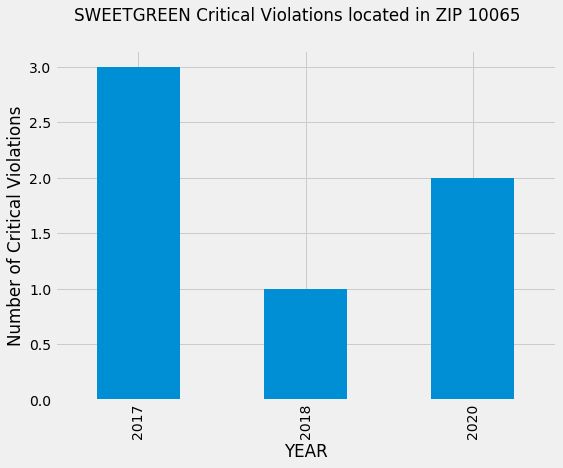

In [59]:
#USER INPUTS: RESTAURANT NAME AND ZIPCODE
rest_variable = input('name of resturant: ')
rest_variable = rest_variable.upper()

zip_variable = input('zipcode: ')

#TEST IF VALID ZIPCODE 
try:
  zip_variable_float = float(zip_variable)
except: 
  print('Invalid Zip')

if zip_variable_float <10000 or zip_variable_float >99999:
  print('Invalid Zip') 

#LOOK UP THE RESTUARANT BY AREA
else: 
  matches = health_grades["NAME"].str.startswith(rest_variable, na=False) 
  health_grades_specific_restaurant = health_grades_Y[matches]

  rest_in_zip = health_grades_specific_restaurant[health_grades_specific_restaurant['ZIPCODE'] == zip_variable_float]

  result = rest_in_zip.groupby('YEAR').count()

#TEST TO SEE IF THERE'S ANY RESULTS 
  try: 
    result['NAME'].plot(kind='bar')
    plt.suptitle(rest_variable + ' Critical Violations located in ZIP ' + str(zip_variable))
    plt.ylabel('Number of Critical Violations')
  except: 
    print('Restaurant not found, please check inputs')


#If you want to see what violations they got... run the code below. 
Sorted by most recent violations

In [60]:
rest_in_zip.sort_values(by=['YEAR', 'INSPECTION DATE'] , ascending=[False, False])

,NAME,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,NEIGHBORHOOD,YEAR,INSPECTION DATE,CRITICAL FLAG,VIOLATION DESCRIPTION
213525,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2020,01/23/2020,Y,Cold food item held above 41º F (smoked fish a...
349330,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2020,01/23/2020,Y,Filth flies or food/refuse/sewage-associated (...
72498,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2018,12/19/2018,Y,Cold food item held above 41º F (smoked fish a...
178211,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2017,12/11/2017,Y,Wiping cloths soiled or not stored in sanitizi...
278126,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2017,02/02/2017,Y,Hot food item not held at or above 140º F.
366551,SWEETGREEN,Salads,Manhattan,786,LEXINGTON AVE,10065.0,Upper East Side,2017,02/02/2017,Y,Cold food item held above 41º F (smoked fish a...


## General analysis on restaurant health inspection data in 2019 

In [41]:
#FILTER OUT 2019 DATA FROM REST OF DATASET 
health_grades_2019_all= health_grades[health_grades['YEAR'] == 2019]
health_grades_2019= health_grades_Y[health_grades_Y['YEAR'] == 2019]

#BREAK OUT HOW MANY RESTUARANTS THERE ARE IN NYC KEEPING IN MIND THAT RESTAURANTS MAY HAVE MORE THAN ONE LOCATION 
num_of_rest_2019 = health_grades_2019_all[['NAME', 'CUISINE DESCRIPTION', 'NEIGHBORHOOD', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE']]
num_of_rest_2019['combined'] = num_of_rest_2019['NAME'].str.cat(num_of_rest_2019['BUILDING'],sep=" ")
num_of_rest_2019['combined'] = num_of_rest_2019['combined'].str.cat(num_of_rest_2019['STREET'],sep=" ")
num_of_rest_2019 = num_of_rest_2019[['NAME', 'CUISINE DESCRIPTION', 'NEIGHBORHOOD', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE','combined'] ]

num_of_rest_2019.drop_duplicates(subset ="combined", keep = 'first', inplace = True) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Let's figure out which neghborhoods have most critical health violations 

Text(0, 0.5, 'Number of Critical Violations')

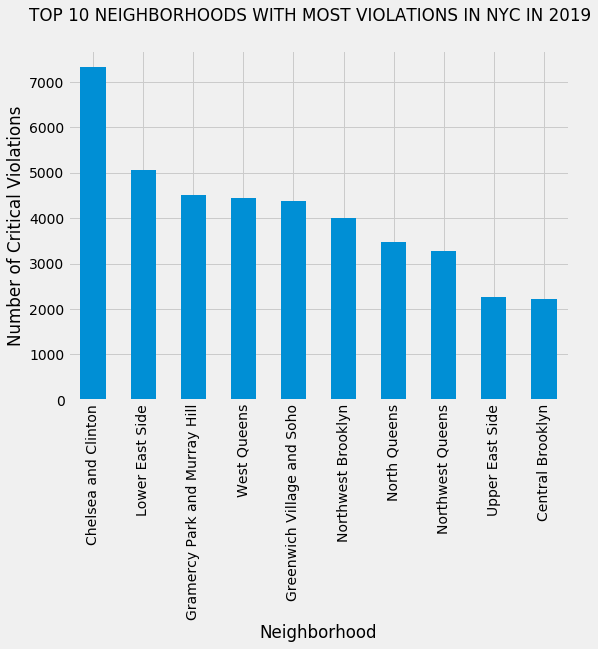

In [62]:
#Count how many critical violations and chart it
health_grades_2019['NEIGHBORHOOD'].value_counts() 
health_grades_2019['NEIGHBORHOOD'].value_counts().head(10).plot(kind='bar')
plt.suptitle('TOP 10 NEIGHBORHOODS WITH MOST VIOLATIONS IN NYC IN 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Critical Violations')



# Chelsea and clinton definitely have a lot of restaurants... 
# Let's see how many restaurants per neighborhood

Text(0, 0.5, 'Number of Restaurants')

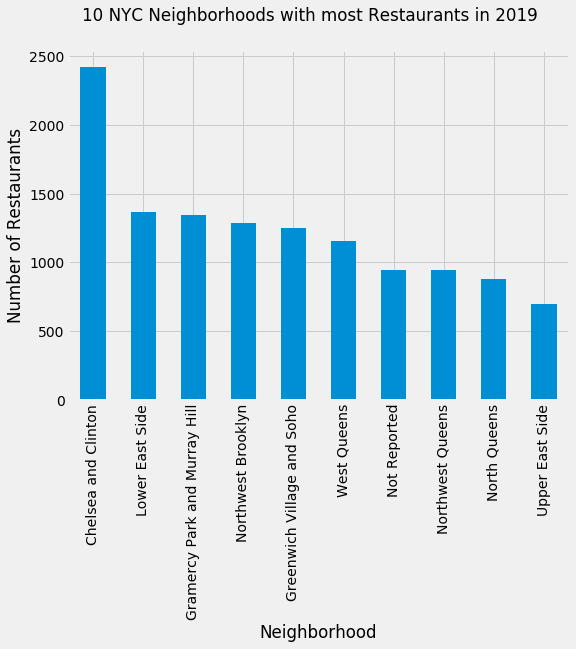

In [43]:
#Find the number of restaurants in each neighborhood and chart 
num_of_rest_2019_Y['NEIGHBORHOOD'].value_counts().head(10).plot(kind='bar')
plt.suptitle('10 NYC Neighborhoods with most Restaurants in 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Restaurants') 

# Neighborhoods with most violations normalized by number of restaurants 

Text(0, 0.5, 'Number of Violations / Number of Restaurants')

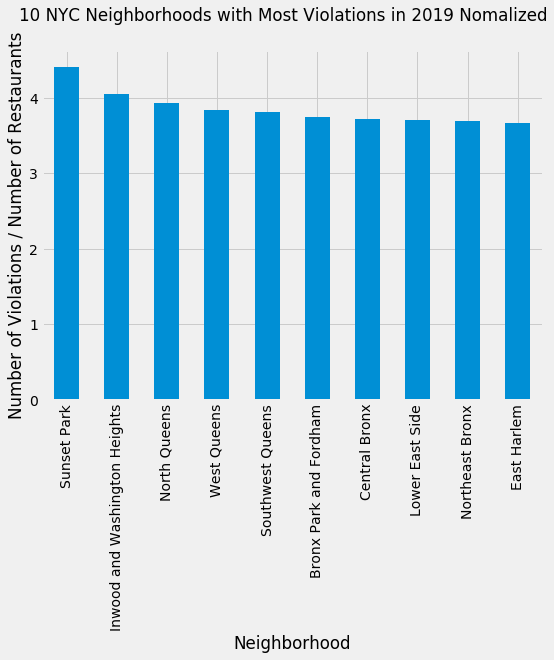

In [44]:
# Let's normalize this data by how many restaurants are in the neighborhoods
num_of_rest_n = num_of_rest_2019['NEIGHBORHOOD'].value_counts()
num_of_rest_v = health_grades_2019['NEIGHBORHOOD'].value_counts()

violation_per_restaurant = num_of_rest_v.div(num_of_rest_n, level=1, fill_value=0) 
violation_per_restaurant.sort_values(ascending=False).head(10).plot(kind='bar')
plt.suptitle('10 NYC Neighborhoods with Most Violations in 2019 Nomalized')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Violations / Number of Restaurants')

# Let's do the same thing with least violations by neighborhood normalized

Text(0, 0.5, 'Number of Violations / Number of Restaurants')

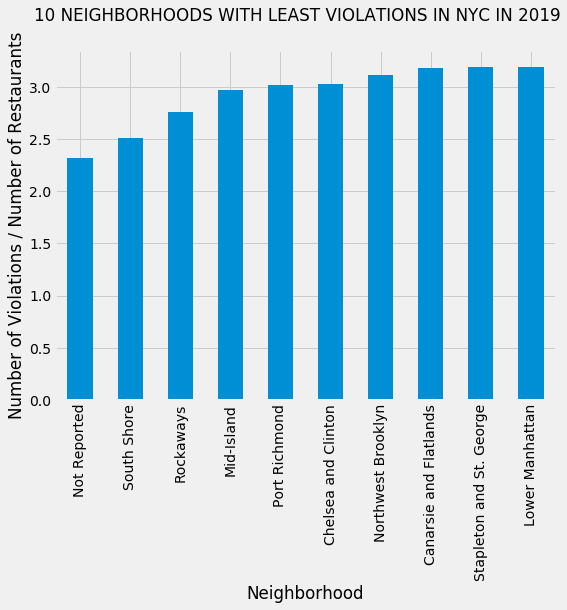

In [45]:
violation_per_restaurant.sort_values(ascending=True).head(10).plot(kind='bar')
plt.suptitle('10 NEIGHBORHOODS WITH LEAST VIOLATIONS IN NYC IN 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Violations / Number of Restaurants')



# Let's figure out which cuisines have most critical health violations 

Text(0.5, 0.98, 'CUSINES WITH MOST VIOLATIONS IN NYC IN 2019')

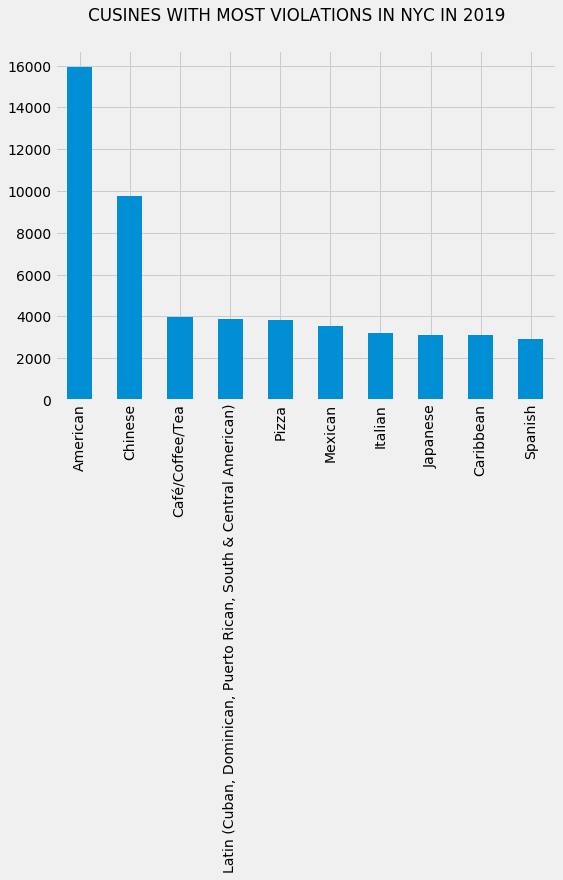

In [46]:
health_grades_2019['CUISINE DESCRIPTION'].value_counts().head(10).plot(kind='bar')

plt.suptitle('CUSINES WITH MOST VIOLATIONS IN NYC IN 2019')

#Then let's figure out how many restaurants by cuisine

Text(0, 0.5, 'Number of Restaurants')

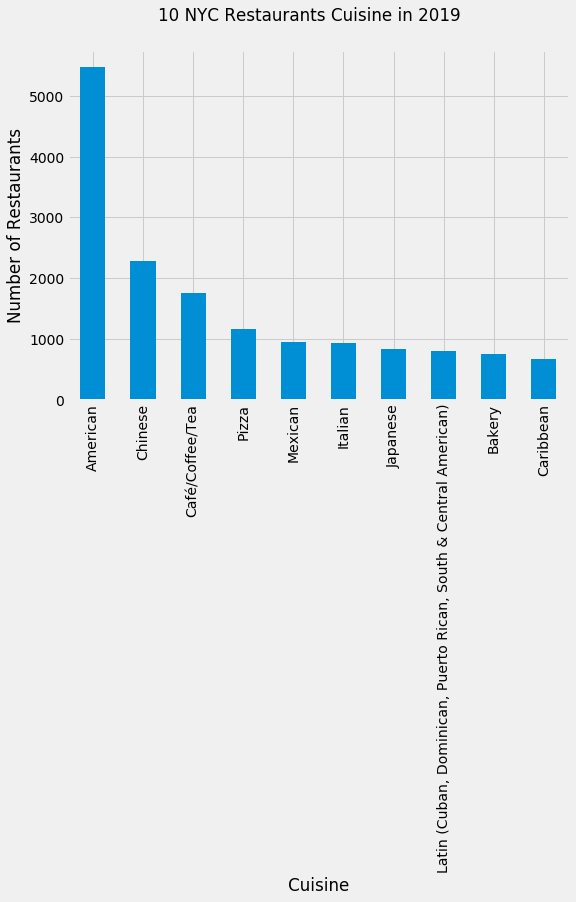

In [48]:
num_of_rest_c = num_of_rest_2019['CUISINE DESCRIPTION'].value_counts()
num_of_rest_c.head(10).plot(kind='bar')
plt.suptitle('Top 10 NYC Restaurants Cuisines in 2019')
plt.xlabel('Cuisine')
plt.ylabel('Number of Restaurants')

# Lastly, normalize it by number of restaurants by cuisine

Text(0, 0.5, 'Number of Violations / Number of Restaurants')

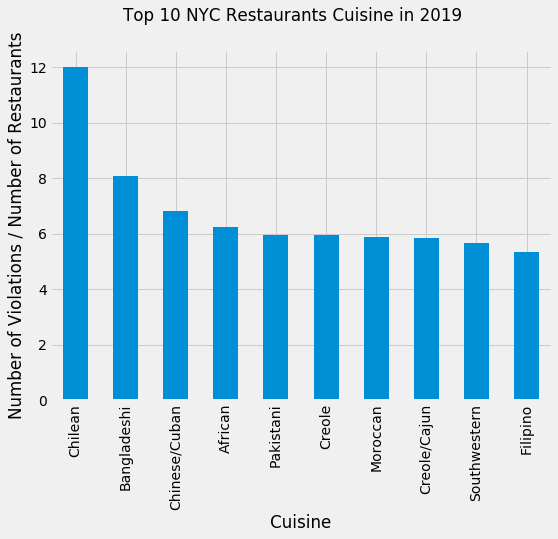

In [49]:
num_of_rest_cv = health_grades_2019['CUISINE DESCRIPTION'].value_counts()
violation_per_restaurant = num_of_rest_cv.div(num_of_rest_c, level=1, fill_value=0) 
violation_per_restaurant.sort_values(ascending=False).head(10).plot(kind='bar')
plt.suptitle('Top 10 NYC Restaurants Violations by Cuisine in 2019')
plt.xlabel('Cuisine') 
plt.ylabel('Number of Violations / Number of Restaurants')


Text(0, 0.5, 'Number of Violations / Number of Restaurants')

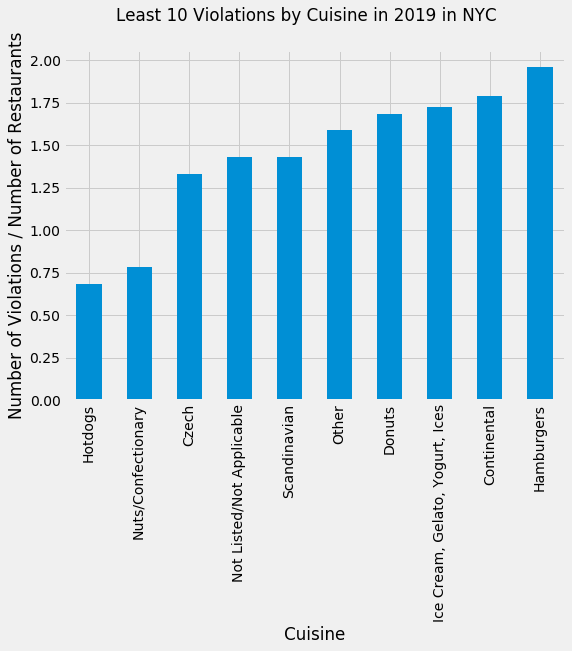

In [63]:
violation_per_restaurant.sort_values(ascending=True).head(10).plot(kind='bar')
plt.suptitle('Least 10 Violations by Cuisine in 2019 in NYC')
plt.xlabel('Cuisine') 
plt.ylabel('Number of Violations / Number of Restaurants')
